# Setup

In [270]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [271]:
import attr

In [1]:
import torch
torch.__version__

'1.0.0'

In [3]:
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import models

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Prepare Data

In [5]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

In [6]:
matplotlib.__version__

'3.0.1'

In [177]:
def plot_image(img):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img);

In [8]:
# len(images), len(labels)

# Load Data

In [8]:
from pathlib import Path
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import img_to_tensor
from albumentations import (
    PadIfNeeded
)

In [9]:
base_path = Path('data/raw')

In [10]:
full_size = 4096
n_splits = 8
tile_size = full_size // n_splits
tile_size

512

In [11]:
image_dirs = [image_dir for image_dir in base_path.iterdir()]
image_dirs

[PosixPath('data/raw/n1_SELECTED'),
 PosixPath('data/raw/c2_SELECTED'),
 PosixPath('data/raw/h3_SELECTED')]

In [ ]:
from sklearn.model_selection import train_test_split

In [12]:
train_dirs, valid_dirs = \
    train_test_split(image_dirs, test_size=0.3, random_state=42)

In [13]:
train_dirs, valid_dirs

([PosixPath('data/raw/c2_SELECTED'), PosixPath('data/raw/h3_SELECTED')],
 [PosixPath('data/raw/n1_SELECTED')])

In [34]:
def slice_image(image, n_splits):
    tile_size = image.shape[0] // n_splits
    tiles = []
    for i in range(n_splits):
        for j in range(n_splits):
            tile = image[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
            tiles.append(tile)
    return tiles

class AMDataset(Dataset):
    def __init__(self, image_dirs, full_size, n_splits, transform=None):
        self.transform = transform
        self.source_image_padding = {}
        self.images, self.masks = self.slice_images_masks(image_dirs, full_size, n_splits)
    
    def slice_images_masks(self, image_dirs, full_size, n_splits):
        ''' N.B. All dirs should contains or should not contain masks '''
        aug = PadIfNeeded(min_height=full_size, min_width=full_size,
                          border_mode=cv2.BORDER_REFLECT_101, p=1.0)

        images, masks = [], []
        for image_dir in image_dirs:
            print(image_dir)

            source_image = cv2.imread(str(image_dir / 'source.png'))

            self.source_image_padding[image_dir] = [full_size - x for x in source_image.shape[:2]]
            print(f'Images padded with {self.source_image_padding[image_dir]}')

            images += slice_image(aug(image=source_image)['image'], n_splits)
            
            if (image_dir / 'mask.png').exists():
                source_mask = cv2.imread(str(image_dir / 'mask.png'))
                masks += slice_image(aug(image=source_mask)['image'], n_splits)

        return images, masks
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx][:,:,:1] if self.masks else None
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        return img_to_tensor(image), img_to_tensor(mask)

In [53]:
# train_ds = AMDataset(train_dirs, full_size=full_size, n_splits=n_splits, transform=None)
# valid_ds = AMDataset(valid_dirs, full_size=full_size, n_splits=n_splits, transform=None)

In [54]:
# len(train_ds), len(valid_ds)

# Define Models

In [19]:
# https://github.com/ternaus/TernausNet/blob/master/unet_models.py

In [13]:
def conv3x3(in_ch, out_ch):
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, dilation=1)

In [14]:
class ConvRelu(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = conv3x3(in_ch, out_ch)
        self.activation = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

In [15]:
class Interpolate(nn.Module):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super().__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners
    
    def forward(self, x):
        x = self.interp(x, size=self.size, scale_factor=self.scale_factor,
                        mode=self.mode, align_corners=self.align_corners)
        return x

In [16]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch, upsampling=False):
        super().__init__()
        self.in_ch = in_ch
        
        if not upsampling:
            self.block = nn.Sequential(
                ConvRelu(in_ch, mid_ch),
                nn.ConvTranspose2d(mid_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                Interpolate(scale_factor=2, mode='bilinear'),
                ConvRelu(in_ch, mid_ch),
                ConvRelu(mid_ch, out_ch)
            )
    
    def forward(self, x):
        return self.block(x)

In [17]:
class UNet11(nn.Module):
    def __init__(self, num_filters=32, pretrained=True):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        
        encoder = models.vgg11(pretrained=True).features
        
        self.conv1 = encoder[0]  # 3 -> 64
        self.conv2 = encoder[3]  # 64 -> 128
        self.conv3_1 = encoder[6]  # 128 -> 256
        self.conv3_2 = encoder[8]  # 256 -> 256
        self.conv4_1 = encoder[11]  # 256 -> 512
        self.conv4_2 = encoder[13]  # 512 -> 512
        self.conv5_1 = encoder[16]  # 512 -> 512
        self.conv5_2 = encoder[18]  # 512 -> 512
        
        self.center = DecoderBlock(num_filters * 16, num_filters * 16, num_filters * 8)
        
        self.dec5 = DecoderBlock(num_filters * (8 + 16), num_filters * 16, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (8 + 16), num_filters * 16, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (4 + 8), num_filters * 8, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (2 + 4), num_filters * 4, num_filters)
        self.dec1 = ConvRelu(num_filters * (1 + 2), num_filters)
        
        self.final = nn.Conv2d(num_filters, 1, kernel_size=1)
        
    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3_1 = self.relu(self.conv3_1(self.pool(conv2)))
        conv3_2 = self.relu(self.conv3_2(conv3_1))
        conv4_1 = self.relu(self.conv4_1(self.pool(conv3_2)))
        conv4_2 = self.relu(self.conv4_2(conv4_1))
        conv5_1 = self.relu(self.conv5_1(self.pool(conv4_2)))
        conv5_2 = self.relu(self.conv5_2(conv5_1))
        
        center = self.center(self.pool(conv5_2))
        
        dec5 = self.dec5(torch.cat([center, conv5_2], dim=1))
        dec4 = self.dec4(torch.cat([dec5, conv4_2], dim=1))
        dec3 = self.dec3(torch.cat([dec4, conv3_2], dim=1))
        dec2 = self.dec2(torch.cat([dec3, conv2], dim=1))
        dec1 = self.dec1(torch.cat([dec2, conv1], dim=1))
        
        return self.final(dec1)

In [25]:
# unet11 = UNet11()

# Train Models

In [23]:
from torch.optim import Adam
from torch.utils.data import DataLoader
import time
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    Normalize,
    Compose,
    PadIfNeeded,
    RandomCrop,
    CenterCrop
)

In [24]:
class LossBinary(object):
    """ Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard
    """
    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = torch.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [25]:
def jaccard(y_pred, y_true):
    y_true = torch.squeeze(y_true, dim=1)
    y_pred = torch.squeeze(y_pred, dim=1)
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1)
    union = y_true.sum(dim=-2).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1)
    return ((intersection + epsilon) / (union - intersection + epsilon))

In [26]:
def train_transform(p=1):
    return Compose([
#         PadIfNeeded(min_height=args.train_crop_height, min_width=args.train_crop_width, p=1),
#         RandomCrop(height=args.train_crop_height, width=args.train_crop_width, p=1),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
        Normalize(p=1)
    ], p=p)

def valid_transform(p=1):
    return Compose([
#         PadIfNeeded(min_height=args.val_crop_height, min_width=args.val_crop_width, p=1),
#         CenterCrop(height=args.val_crop_height, width=args.val_crop_width, p=1),
        Normalize(p=1)
    ], p=p)

In [143]:
train_ds = AMDataset(train_dirs, full_size=full_size, n_splits=n_splits, transform=train_transform())
valid_ds = AMDataset(valid_dirs, full_size=full_size, n_splits=n_splits, transform=valid_transform())

data/raw/c2_SELECTED
Padded with: [200, 180]
data/raw/h3_SELECTED
Padded with: [331, 290]
data/raw/n1_SELECTED
Padded with: [398, 349]


In [144]:
batch_size = 2
train_dl = DataLoader(
    dataset=train_ds,
    shuffle=True,
    num_workers=4,
    batch_size=batch_size,
    pin_memory=torch.cuda.is_available()
)
valid_dl = DataLoader(
    dataset=valid_ds,
    shuffle=False,
    num_workers=4,
    batch_size=batch_size,
    pin_memory=torch.cuda.is_available()
)

In [145]:
len(train_dl), len(valid_dl)

(64, 32)

In [31]:
lr = 1e-3
n_epochs = 5

In [32]:
model = UNet11()
model.to('cuda')
optimizer = Adam(model.parameters(), lr=lr)
criterion = LossBinary(jaccard_weight=0)

In [33]:
# plot_img(torch.sigmoid(outputs)[0,0,:,:].detach())

In [34]:
# plot_img(outputs.detach().numpy().squeeze())

In [35]:
start = time.time()
for epoch in range(0, n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')
    print('-' * 10)
    model.train()
    
    running_loss, running_metric = 0.0, 0.0
    for i, (inputs, targets) in enumerate(train_dl):
        print('.', end='')
        inputs = inputs.to('cuda')
        
        with torch.no_grad():
            targets = targets.to('cuda')
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_metric += jaccard((outputs > 0).float(), targets).sum().item()
    
    running_loss /= len(train_dl.dataset)
    running_metric /= len(train_dl.dataset)
    print(f'\nTrain loss: {running_loss:.5f}, train metric: {running_metric:.5f}')
    
    with torch.no_grad():
        model.eval()
        losses, metrics = [], []
        for inputs, targets in valid_dl:
            print('.', end='')
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            losses.append(loss.item() * inputs.size(0))
            metric = jaccard((outputs > 0).float(), targets).sum().item()
            metrics.append(metric)

        valid_loss = sum(losses) / len(valid_dl.dataset)
        valid_metric = sum(metrics) / len(valid_dl.dataset)

        print(f'\nValid loss: {valid_loss:.5f}, jaccard: {valid_metric:.5f}')
    
    elapsed = int(time.time() - start)
    print(f'{elapsed // 60} min {elapsed % 60} sec')

Epoch 1/5
----------
................................................................
Train loss: 0.16356, train metric: 0.39410
................................
Valid loss: 0.03482, jaccard: 0.70797
1 min 9 sec
Epoch 2/5
----------
................................................................
Train loss: 0.03707, train metric: 0.77229
................................
Valid loss: 0.02943, jaccard: 0.74921
2 min 19 sec
Epoch 3/5
----------
................................................................
Train loss: 0.03326, train metric: 0.76991
................................
Valid loss: 0.02537, jaccard: 0.77185
3 min 29 sec
Epoch 4/5
----------
................................................................
Train loss: 0.03170, train metric: 0.80077
................................
Valid loss: 0.02584, jaccard: 0.76549
4 min 40 sec
Epoch 5/5
----------
................................................................
Train loss: 0.02979, train metric: 0.79309
....................

In [264]:
torch.save(model.state_dict(), open('unet.pth', 'wb'))

---

# Test Images

In [146]:
inputs, targets = next(iter(valid_dl))
inputs.shape, targets.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 1, 512, 512]))

In [47]:
outputs = model(inputs.to('cuda'))
outputs.shape

torch.Size([2, 1, 512, 512])

In [48]:
targets_pred = torch.sigmoid(outputs)

In [49]:
def convert_to_image(tensor):
    tensor = tensor[0]
    return tensor.detach().cpu().numpy()

In [50]:
def plot_images(images):
    n = min(len(images), 3)
    fig, axes = plt.subplots(1, n, figsize=(16, 8))
    for i in range(n):
        axes[i].imshow(images[i]);

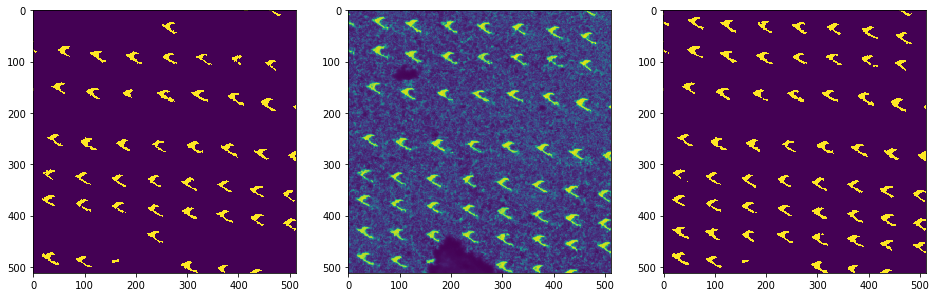

In [51]:
i = 0
plot_images([
    convert_to_image(targets[i]),
    convert_to_image(inputs[i]),
#     convert_to_image(outputs[0])
    convert_to_image(targets_pred[i] > 0.3),
#     convert_to_image(outputs[0] > 0),
])

In [62]:
# plot_img(convert_to_image(targets_pred[0]))

In [37]:
def predict_mask(dl, model, threshold=0.3):
    pred_outputs = []
    with torch.no_grad():
        model.eval()
        for inputs, targets in dl:
            inputs = inputs.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs) > threshold
            pred_outputs.append(outputs)
    pred_outputs = torch.squeeze(torch.cat(pred_outputs))
    pred_outputs = pred_outputs.detach().cpu().numpy()
    return pred_outputs

# Inference

In [42]:
import cv2
import numpy as np

In [18]:
model = UNet11()

In [20]:
state = torch.load(open('unet.pth', 'rb'), map_location='cpu')
model.load_state_dict(state)
model = model.to(device)

In [38]:
test_dir = Path('data/raw/n1_SELECTED')
test_ds = AMDataset([test_dir], full_size=full_size, n_splits=n_splits, transform=valid_transform())

test_dl = DataLoader(
    dataset=test_ds,
    shuffle=False,
    num_workers=4,
    batch_size=2,
    pin_memory=False
)

test_pred = predict_mask(test_dl, model, threshold=0.3)

data/raw/n1_SELECTED
Images padded with [398, 349]


In [39]:
def combine_tiles(tiles, full_size, n_splits):
    tile_size = full_size // n_splits
    image = np.zeros((full_size, full_size))
    for i in range(n_splits):
        for j in range(n_splits):
            tile = tiles[i * n_splits + j]
            image[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size] = tile
    return image

In [40]:
def remove_padding(image, full_size, row_pad, col_pad):
    top_pad = row_pad // 2
    bottom_pad = row_pad - top_pad
    left_pad = col_pad // 2
    right_pad = col_pad - left_pad
    return image[top_pad:(full_size - bottom_pad), left_pad:(full_size - right_pad)]

In [43]:
test_mask_pred = combine_tiles(test_pred, full_size, n_splits)
row_pad, col_pad = test_ds.source_image_padding[test_dir]
test_mask_pred_crop = remove_padding(test_mask_pred, full_size, row_pad, col_pad)

In [286]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(test_mask_pred);

In [261]:
# test_mask_pred_crop.shape

In [263]:
# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(test_mask_pred_crop);

In [253]:
# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(np.stack([test_mask_pred_crop]*3, axis=2));

# Other

In [158]:
valid_input_image = cv2.imread(str(valid_dirs[0] / 'source.png'))

In [163]:
nrows, ncols = valid_input_image.shape[:2]
nrows, ncols

(3698, 3747)

In [258]:
# plot_image(valid_input_image[:,:,0])

In [259]:
# plot_image(valid_mask_crop)

In [260]:
# valid_mask_real = cv2.imread(str(valid_dirs[0] / 'mask.png'))
# plot_image(valid_mask_real[:,:,0])

In [78]:
aug = PadIfNeeded(min_height=6, min_width=6, border_mode=cv2.BORDER_CONSTANT, p=1.0)

In [86]:
a = np.arange(1, 10).reshape(3, 3)

In [87]:
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [88]:
aug(image=a)['image']

array([[0, 0, 0, 0, 0, 0],
       [0, 1, 2, 3, 0, 0],
       [0, 4, 5, 6, 0, 0],
       [0, 7, 8, 9, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int32)